[View in Colaboratory](https://colab.research.google.com/github/Saintat1/Kaggle/blob/master/salt_detection.ipynb)

In [0]:
!pip install torch
!pip install imageio

In [0]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data

In [0]:
class TGSSaltDataset(data.Dataset):
  
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, index):
    if index not in range(0, len(self.file_list)):
      return self.__getitem__(np.random.ranint(0 , self.__len__()))
    
    file_id = self.file_list[index]
    
    image_folder = os.path.join(self.root_path, "images")
    image_path = os.path.join(image_folder, file_id + ".png")
    
    mask_folder = os.path.join(self.root_path, "masks")
    mask_path = os.path.join(mask_folder, file_id + ".png")
    
    #transfer image to np array
    image = np.array(imageio.imread(image_path), dtype = np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype = np.uint8)
    
    return image, mask

In [0]:
!pip install kaggle

In [0]:
# use kaggle api Token to download dataset
from google.colab import files
files.upload()        

In [0]:
!ls -lha kaggle.json

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json   # authorize

In [0]:
!kaggle competitions download -c tgs-salt-identification-challenge

In [0]:
!ls
!unzip train.zip

In [0]:
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')
train_path = "./"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [0]:
type(train_mask['rle_mask'][1])

In [0]:
def plot2x2Array(image,mask):
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

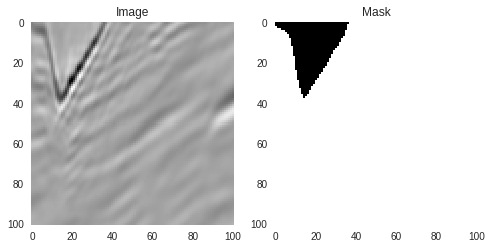

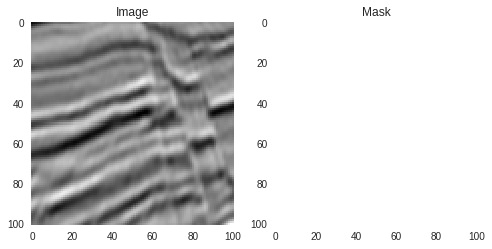

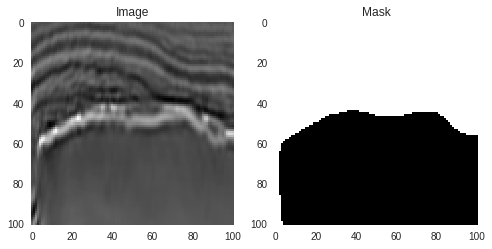

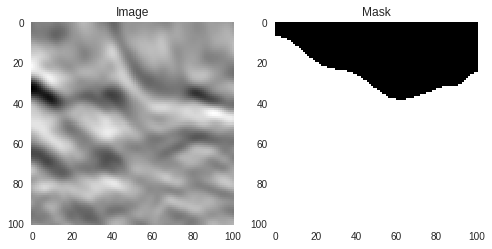

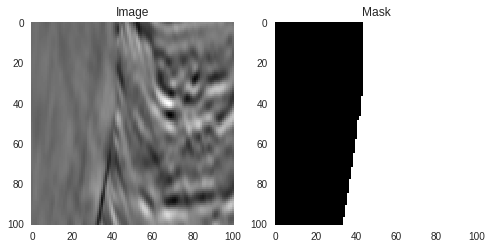

In [15]:
for i in range(5):
  image, mask = dataset[np.random.randint(0,len(dataset))]
  plot2x2Array(image, mask)

Text(0.5,1,'Depth distribution')

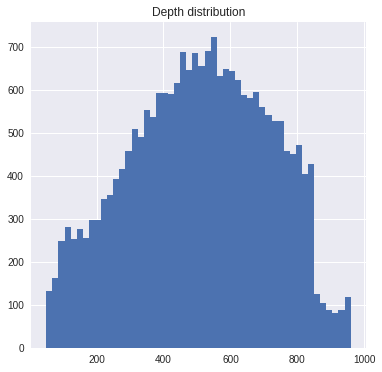

In [16]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

In [0]:
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
        
        print(rleString)
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    print(img)
    
    return img

In [0]:
def salt_proportion(imgArray):
  #print(imgArray)
  unique, counts = np.unique(imgArray, return_counts=True)
  print(unique)
  print(counts)
  try:
    unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
    print(counts[1])
    return (counts[1]/10201.)
    
  except:
    return 0.0

In [0]:
train_mask['rle_mask']

In [0]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))

In [0]:
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [21]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt vs. depth')

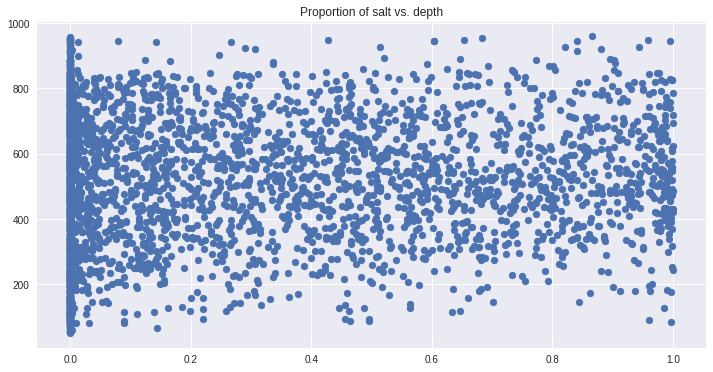

In [22]:
plt.figure(figsize = (12,6))
plt.scatter(merged['salt_proportion'],merged['z'])
plt.title('Proportion of salt vs. depth')

In [0]:
np.corrcoef(merged['salt_proportion'],merged['z'])[0][1]    # almost non-correlated

0.10361580365557428

In [0]:
# when it comes to computer vison, these methods outperfoms most of the time:
# AlexNet(ImageNet 2012): similiar to LeNet, but was deeper, bigger, and featured Conv layers stacked on top of each other(instead of a Conv layer follwed by a pooling layer)
# VGG-16, VGG-19(ImageNet 2012): depth of netword is critical, using 16/19 Conv/FC layer, 3x3 Conv and 2x2 max pooling. Downside: 1. more expensive to evaluate 2. uses a lot of memory(most used for first FC layer)
# Inception Nets(2014, GoogLeNet): 1.has a inception module-->reduce #parameters 2. Use average pooling instead of FC layer on top of Conv layer --> reduce #parameters
# ResNet(2015. default method for CNN for now) 1. use skip connections 2. use batch normalization 3. not using FC layers at the end of the network
# Squeeze  Net

In [0]:
# When to use U-net:
#1. image classification tasks, when we need to segment areas of image by class, 如此处， for each pixel, predict it's 0 or 255
#2. many layers takes significatn time to train
#3. U net is designed as auto-encoder, but it predicts pixelwise segmentation map of input image
#4. "U shape" : encouding path(contracting) and decoding path(expanding)
#5. similiar to ResNet
 

In [0]:
ReLu: rectified linear unit 
ELU: exponential linear unit

batchnorm

maxpool(downsampling)

upsample

dropout



In [23]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2
n_features = 1

In [0]:
input_img = Input((im_height ,im_width, im_chan), name = 'img')
input_features = Input((n_features, ), name = 'feat')

c1 = Conv2D(8,(3,3), activation = 'relu', padding = 'same')(input_img)
# 8 is the the dimensionality of the output space (i.e. the number of output filters in the convolution)
# (3,3) is the size of the sliding window
# padding: one of 'valid' or 'same'
c1 = Conv2D(8,(3,3), activation = 'relu', padding = 'same')(c1)
p1 = MaxPooling2D((2,2))(c1)  # 128*128  --> 64*64  maxpooling的作用？


In [0]:
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2) # 32*32

In [0]:
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4) # 8*8

In [28]:
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8,8,n_features))(f_repeat)
p4_feat = concatenate([p4,f_conv], -1)  # why add this to p4?

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# stride: : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. 
# Can be a single integer to specify the same value for all spatial dimensions
u6 = Conv2DTranspose(64,(2,2), strides=(2,2), padding = 'same')(c5)
#The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, 
# i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.



u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()


# skip connection


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
!pip install ipywidgets

In [30]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:21<00:00, 189.05it/s]

Done!


In [0]:
train_ids = next(os.walk(train_path+"images"))[2]
np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [33]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 280s 82ms/step - loss: 0.0381 - val_loss: 1.0000e-07

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 277s 82ms/step - loss: 1.0000e-07 - val_loss: 1.0000e-07

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
3400/3400 [==============================] - 279s 82ms/step - loss: 1.0000e-07 - val_loss: 1.0000e-07

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
3400/3400 [==============================] - 279s 82ms/step - loss: 1.0000e-07 - val_loss: 1.0000e-07

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
3400/3400 [==============================] - 278s 82ms/step - loss: 1.0000e-07 - val_loss: 1.0000e-07

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
34